<a href="https://colab.research.google.com/github/Yahia0mohamed/ML_projects/blob/main/decisionTreeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Learning**
This project is based on classification using decision tree

# **Importing needed libraries**

In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [158]:
tennisData=pd.read_csv('/content/PlayTennis.csv')
tennisData.head(14)

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [159]:
dummies_dict={
    'Yes':1,
    'No':0
}
tennisData['Play Tennis']=tennisData['Play Tennis'].map(dummies_dict)


tennisData.head(14)


,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,0
1,Sunny,Hot,High,Strong,0
2,Overcast,Hot,High,Weak,1
3,Rain,Mild,High,Weak,1
4,Rain,Cool,Normal,Weak,1
5,Rain,Cool,Normal,Strong,0
6,Overcast,Cool,Normal,Strong,1
7,Sunny,Mild,High,Weak,0
8,Sunny,Cool,Normal,Weak,1
9,Rain,Mild,Normal,Weak,1


# **Creating the Decision Tree class and the node class**

In [162]:
class Node:
    def __init__(self, feature=None, value=None, prediction=None):
        self.feature = feature      # Feature used for splitting
        self.value = value          # Value of the feature if this is a non-leaf node
        self.prediction = prediction  # Class prediction if this is a leaf node
        self.children = {}          # Dictionary to store child nodes

    def add_child(self, value, node):
        self.children[value] = node

    def __repr__(self):
        if self.prediction is not None:
            return f"Leaf Node: Prediction={self.prediction}"
        else:
            return f"Internal Node: Feature={self.feature}, Value={self.value}"

In [173]:
class DecisionTree:
  def __init__(self):
        pass

  def fit(self, x, y):
      self.__x_train = x
      self.__y_train = y
      self.__targetName = y.name
      self.__data_set = pd.concat([x,y], axis=1)

  def __entropy(self):
      pPositive = (self.__y_train == 1).sum() #positive class count
      pNegative = (self.__y_train == 0).sum() #negative class count

      if pPositive == 0 or pNegative == 0:
          return 0  # If all instances are of one class, entropy is 0
      total_instances = len(self.__y_train)
      positive_prob = pPositive / total_instances
      negative_prob = pNegative / total_instances
      return -(positive_prob * m.log2(positive_prob) + negative_prob * m.log2(negative_prob))

  def __entropyPerFeature(self, feature, data_set):
      entropy_per_feature = 0
      unique_occurrences = self.__x_train[feature].unique()
      unique_label_counts = self.__x_train[feature].value_counts()
      unique_counts = data_set.groupby([feature, self.__targetName]).size().unstack(fill_value=0)
      for i in unique_occurrences:
          pPositive = unique_counts[1].get(i, 0)
          pNegative = unique_counts[0].get(i, 0)
          if pPositive == 0 or pNegative == 0:
              feature_entropy = 0
          elif pPositive == pNegative:
              feature_entropy = 1
          else:
              positive_prob = pPositive / (pPositive + pNegative)
              negative_prob = pNegative / (pPositive + pNegative)
              feature_entropy = -(positive_prob * m.log2(positive_prob) + negative_prob * m.log2(negative_prob))
          weight = (unique_label_counts[i] / len(data_set))
          entropy_per_feature += weight * feature_entropy
      return entropy_per_feature

  def __avgEntropy(self, feature, data_set):
      return self.__entropyPerFeature(feature, data_set)

  def __informationGain(self, feature):
      return self.__entropy() - self.__avgEntropy(feature, self.__data_set)

  def buildTree(self,max_depth=3):
        return self.__buildTreeRecursive(self.__data_set, self.__x_train.columns.tolist(), max_depth)

  def __buildTreeRecursive(self, data_set, features, depth):
      # Check if data is pure or if we have reached maximum depth
      if len(set(data_set[self.__targetName])) == 1 or depth == 0:
          # Create a leaf node with the most common class label as the prediction
          prediction = data_set[self.__targetName].mode()[0]
          return Node(prediction=prediction)
      # Select the best feature to split on
      best_feature = None
      best_info_gain = -1
      for feature in features:
          info_gain = self.__informationGain(feature)
          if info_gain > best_info_gain:
              best_info_gain = info_gain
              best_feature = feature
      # Partition the data based on the best feature
      subsets = {}
      for value in data_set[best_feature].unique():
          subsets[value] = data_set[data_set[best_feature] == value]
      # Recursively build subtrees
      branches = {}
      for value, subset in subsets.items():
          subtree = self.__buildTreeRecursive(subset, [f for f in features if f != best_feature], depth - 1)
          branches[value] = subtree
      # Create an internal node for the best feature
      node = Node(feature=best_feature)
      # Add child nodes
      for value, subtree in branches.items():
          node.add_child(value, subtree)
      return node

  def printTree(self, node=None, indent=""):
    if node is None:
        node = self.build_tree()  # Get the root node if not provided

    if node.prediction is not None:
        print(indent + "Leaf Node: Prediction =", node.prediction)
        return

    print(indent + f"Internal Node: Feature = {node.feature}")
    for value, child in node.children.items():
        print(indent + f"  Value = {value}")
        self.print_tree(child, indent + "    ")

# **Testing our decision tree class and plotting the tree**

In [174]:
x_train = tennisData.drop('Play Tennis', axis=1)
y_train = tennisData['Play Tennis']

import graphviz

def plot_tree(node, dot=None):
    if dot is None:
        dot = graphviz.Digraph()

    if node.prediction is not None:
        dot.node(str(id(node)), label=f"Prediction={node.prediction}")
    else:
        dot.node(str(id(node)), label=f"Feature={node.feature}")
        for value, child in node.children.items():
            child_id = plot_tree(child, dot)
            dot.edge(str(id(node)), str(child_id), label=str(value))

    return id(node)

decision_tree = DecisionTree()
decision_tree.fit(x_train, y_train)
root_node = decision_tree.buildTree()
dot = graphviz.Digraph()
plot_tree(root_node, dot)
dot.render('decision_tree', format='png', cleanup=True)

'decision_tree.png'

#**this is the tree after plotting** 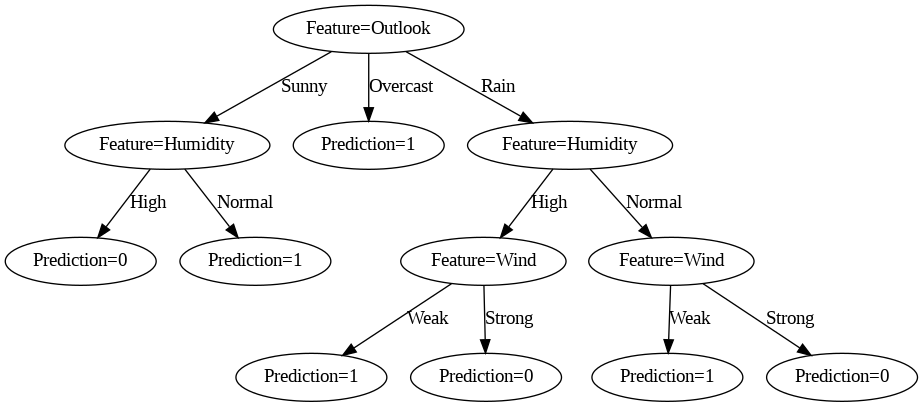